# Clasificación de Erupciones Volcánicas

## Objetivos  
* Realizar un modelo predictivo basado en **Random Forests** que permita conocer el tipo de erupción que tendrá un volcán en función de las vibraciones medidas por los sensores.  
* Una vez se haya hecho y entrenado el modelo predictivo, este se tendrá que **emplear con los features del dataset de testing 'jm_test_X.csv'**. Estas predicciones se tendrán que entregar en formato csv. 
* La calidad de la predicción se medirá a partir del **f1-score (macro).**


**IMPORT LIBRARIES:**

In [1]:
#data exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#preprocessing libraries
from scipy import stats
from scipy.stats import shapiro
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

#model selection and algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

**1. LOADING AND READING DATA:**

In [2]:
df = pd.read_csv("jm_train.csv")
df.head()

,feature1,feature2,feature3,feature4,feature5,feature6,target
0,0.474335,0.881640,-2.050543,-1.251935,-1.035151,-1.934367,4
1,-1.034675,1.741801,-1.660629,-1.555989,-0.337553,-2.473838,0
2,-0.563221,-0.688381,-0.318415,-1.845172,0.352366,-0.912928,1
3,-1.268179,2.770688,1.054193,2.830389,0.395093,0.677715,3
4,-1.216380,-0.391267,-2.898931,-0.913074,-2.171857,-2.367490,0


**Variables del dataset:**  

* **Features:** El dataset contiene 6 features en 6 columnas, que son los parámetros medidos por los diferentes sensores. Estos corresponden a las vibraciones detectadas en ciertos puntos de la ladera del volcán.  

* **Target:** El target corresponde al 'label' que clasifica los tipos de erupciones volcánicas en función de los features medidos por los sensores.
    * Target 0 corresponde a una erupción de tipo **Pliniana**
    * Target 1 corresponde a una erupción de tipo **Peleana**
    * Target 2 corresponde a una erupción de tipo **Vulcaniana**
    * Target 3 corresponde a una erupción de tipo **Hawaiana**
    * Target 4 corresponde a una erupción de tipo **Estromboliana**


In [3]:
print ('- El dataset contiene', df.shape, 'filas y columnas respectivamente.')
print ('- ¿Existen datos nulos?:', df.isnull().values.any())
print ('- ¿Existen datos faltantes/ erroneos?:', df.isnull().values.any())

- El dataset contiene (2100, 7) filas y columnas respectivamente.
- ¿Existen datos nulos?: False
- ¿Existen datos faltantes/ erroneos?: False


In [4]:
df.nunique()

feature1    2100
feature2    2100
feature3    2100
feature4    2100
feature5    2100
feature6    2100
target         5
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feature1  2100 non-null   float64
 1   feature2  2100 non-null   float64
 2   feature3  2100 non-null   float64
 3   feature4  2100 non-null   float64
 4   feature5  2100 non-null   float64
 5   feature6  2100 non-null   float64
 6   target    2100 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 115.0 KB


In [6]:
df.describe().round(3).T

,count,mean,std,min,25%,50%,75%,max
feature1,2100.0,-0.205,1.544,-6.684,-1.171,-0.444,0.890,4.566
feature2,2100.0,0.199,1.614,-5.383,-0.877,0.321,1.321,6.700
feature3,2100.0,-0.378,1.451,-6.147,-1.366,-0.440,0.663,4.158
feature4,2100.0,-0.206,1.442,-5.654,-1.259,-0.177,0.867,4.372
feature5,2100.0,-0.186,1.502,-5.913,-1.212,-0.196,0.852,5.069
feature6,2100.0,-0.433,1.189,-4.433,-1.132,-0.407,0.349,4.016
target,2100.0,1.980,1.411,0.000,1.000,2.000,3.000,4.000


**2. PREPOCESSING THE DATA:**

Es importante conocer que tipo de distribución tienen los features, así como la existencia de outliers, para determinar el tipo de preprocesado a realizar.

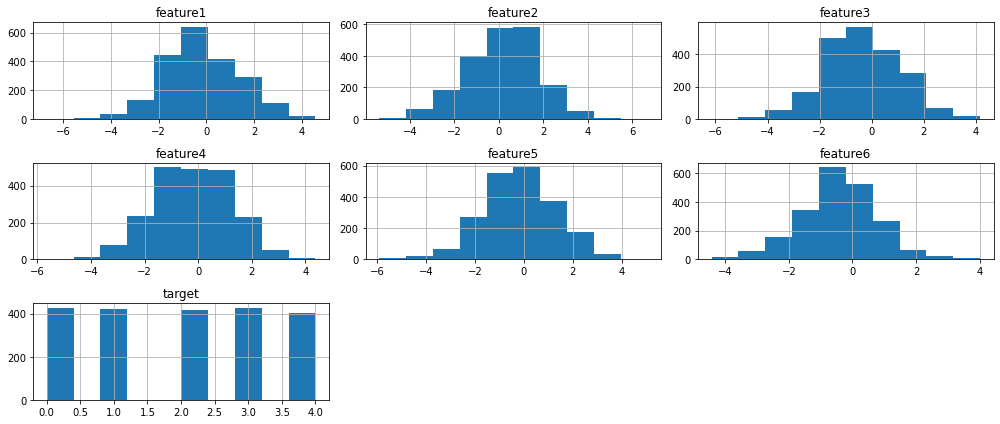

In [7]:
df.hist(figsize=(14,6))
plt.tight_layout()

* Visualmente, parecen no ser distribuciones gaussianas, sin embargo corroboramos mediante p-test.
* Por otro lado, observamos que el **target** está balanceado.

In [8]:
# Shapiro-Wilk Normality Test
for i in df.columns:
    stat, p = shapiro(df[i])
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print(i, ': Probably Gaussian')
    else:
        print(i, ': Probably not Gaussian')

stat=0.989, p=0.000
feature1 : Probably not Gaussian
stat=0.996, p=0.000
feature2 : Probably not Gaussian
stat=0.998, p=0.005
feature3 : Probably not Gaussian
stat=0.997, p=0.000
feature4 : Probably not Gaussian
stat=0.998, p=0.004
feature5 : Probably not Gaussian
stat=0.995, p=0.000
feature6 : Probably not Gaussian
stat=0.889, p=0.000
target : Probably not Gaussian


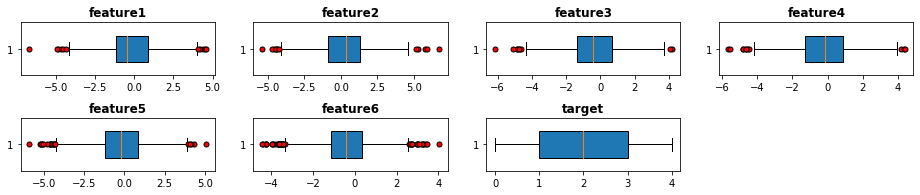

In [9]:
#Creating subplot of each column with its own scale
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='black', ms=5)

fig, axes = plt.subplots(5, 4, figsize=(16, 8))

for idx, (col, ax) in enumerate(zip(df.columns, axes.flatten())):
    ax.boxplot(df[col], flierprops=red_circle, vert=False,
              patch_artist=True, notch = False, widths = 0.5)
    ax.set_title(col, fontweight='bold')
    plt.subplots_adjust(wspace=.2, hspace=.8)
else:
    [ax.set_visible(False) for ax in axes.flatten()[idx+1:]]

* Ningún feature tiene una distribución Gaussiana, sin embargo todos contienen outliers (ver boxplots), por lo tanto se propone realizar una normalización mediante **RobustScaler**.

In [10]:
X = df.drop(['target'],axis=1) #features
y = df['target'] #Target

In [11]:
scalerRobust = RobustScaler().fit(X)
X = scalerRobust.transform(X)

**3. TRAIN / TEST SPLIT:**

- La evaluación, se realiza dividiendo los datos de la siguiente manera: 80% Train y 20% Test.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
print("Shape X_train:", X_train.shape, "\nShape X_test:", X_test.shape, 
      "\nShape y_train:", y_train.shape, "\nShape y_test:",y_test.shape)

Shape X_train: (1680, 6) 
Shape X_test: (420, 6) 
Shape y_train: (1680,) 
Shape y_test: (420,)


**4. CREATE MODEL**

In [13]:
rf = RandomForestClassifier(random_state=42)

   **4.1. MODEL FITTING**

In [14]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

  **4.2. PREDICTION**

In [15]:
y_pred_rf = rf.predict(X_test)

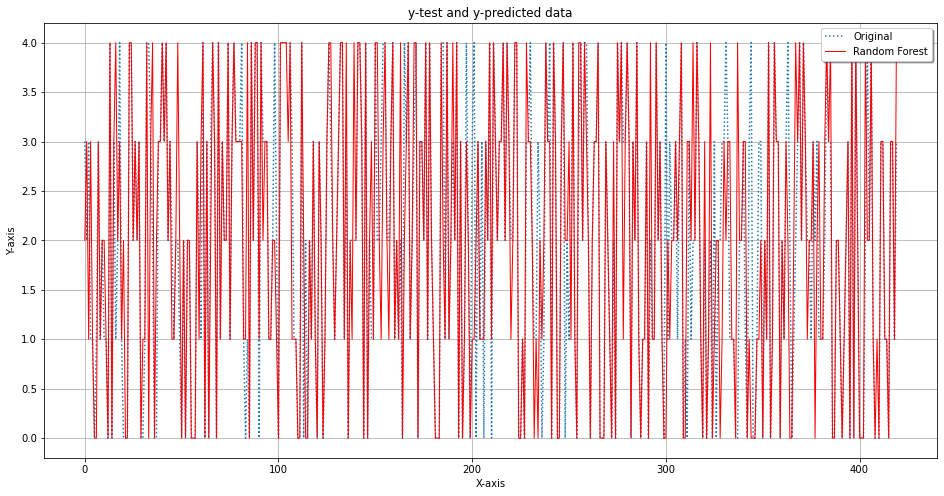

In [16]:
plt.figure(figsize = (16,8))
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, linewidth=1.5, label="Original", ls=":")
plt.plot(x_ax, y_pred_rf, linewidth=1, label="Random Forest", c="red")
plt.title("y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

**5. EVALUATE - F1 score**

In [34]:
f1_rf = f1_score(y_test, y_pred_rf, average='macro')

In [35]:
f1_rf.round(4)

0.7509

**6. CROSS VALIDATION (without hyperparameters)**   

In [38]:
cv_rf = cross_val_score(rf, X, y, cv=5, scoring='f1_macro')
print("F1 for RF mean: {:.4f}, std: {:.2f}".format(cv_rf.mean(), cv_rf.std()) )

F1 for RF mean: 0.7731, std: 0.01


Se obversa que el valor de f1 score tiene un incremento del 2.22%, partiendo de un 75.09% en el modelo vs un 77.31% en cross validation, esto puede deberse a que el test set solo tenia registros de una sola clase.

**7. TUNING THE HYPER-PARAMETERS OF AN ESTIMATOR**  

In [20]:
#param_grid: random forest hyperparameters
param_grid = dict()
param_grid['n_estimators'] = [100, 150, 200]
param_grid['max_features'] = ['sqrt', 'log2', None]
param_grid['max_depth'] = [int(x) for x in np.linspace(10, 110, num = 11)]
param_grid['min_samples_split'] = [2, 5, 10]
param_grid['min_samples_leaf'] = [1, 2, 4]

In [21]:
search = GridSearchCV(rf, param_grid = param_grid, scoring = 'f1_macro')

search.fit(X_train, y_train)

print("Best Hyper-parameters: ", search.best_params_)

Best Hyper-parameters:  {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


**8. PREDICTION WITH HYPER-PARAMETERS**

In [29]:
rf_hp = RandomForestClassifier(max_depth= 20, max_features= 'sqrt', min_samples_leaf= 1, 
                               min_samples_split= 2, n_estimators= 150, random_state=42)

In [30]:
rf_hp.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, max_features='sqrt', n_estimators=150,
                       random_state=42)

In [31]:
y_pred_rf_hp = rf_hp.predict(X_test)

In [32]:
f1_rf_hp = f1_score(y_test, y_pred_rf_hp, average='macro')
f1_rf_hp

0.7574302582322129

El modelo Random Forest con los hyper-parámetros obtenidos, presenta un valor de f1 score = 75.74%, con una mejoría del 0.66% del modelo original.

**9. CROSS VALIDATION (With hyperparameters)**   

In [26]:
cv_rf_hp = cross_val_score(rf_hp, X, y, cv=5, scoring='f1_macro')
print("F1 for RF mean: {:.4f}, std: {:.2f}".format(cv_rf_hp.mean(), cv_rf_hp.std()))

F1 for RF mean: 0.7704, std: 0.01


* El F1 macro más alto obtenido es de aproximadamente **75.74%** con un valor medio de validación cruzada de **77.04%**, estos valores se han obtenido con un escalado previo mediante RobustScaler.  
* Estos resultados son bastante correctos, por lo que se procede a predecir el target con los datos del archivo test.

**10. FINAL PREDICTION ON TESTING DATASET**

In [44]:
#read test file
df2 = pd.read_csv("jm_X_test.csv")

#predict target on test data
target_pred = rf_hp.predict(df2)

#create dataframe with predictions
pred_df = pd.DataFrame(data = target_pred, columns = ["target"])

#save as csv 
pred_df.to_csv("jm_X_prediction.csv", index = False)